In [11]:
%load_ext autoreload
%autoreload 2
from final_project.models import FeedForward
from final_project import builder
from tqdm import tqdm
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from final_project.loader import get_df

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def plot_freq(title, data):
    
    fig, ax = plt.subplots(figsize=(6,3))
    bars = ax.bar(['delayed' if x==1 else 'on time' for x in data[0]], data[1])

    ax.set_title(f'Class Instances in {title.capitalize()} Dataset')
    ax.set_xlabel('Count')
    ax.set_ylabel('Labels')

    print(data[1])
    ax.bar_label(bars, data[1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the chart
    plt.show()

In [15]:
master_df = get_df(year="2018")
master_df = master_df.sample(n=100000, random_state=150)
# builder.runEDA(master_df)
master_df = builder.columnManager(master_df)
master_df = builder.encodeFrame(master_df)

100%|██████████| 12/12 [01:13<00:00,  6.11s/it]


         ArrDel15  DistanceGroup  CarrierDelay  WeatherDelay  NASDelay  \
1812937       0.0              4           0.0           0.0       0.0   
5104019       1.0              5           8.0           0.0       8.0   
27120         1.0              4          42.0           0.0      40.0   
5206655       0.0              2           0.0           0.0       0.0   
1662881       0.0              2           0.0           0.0       0.0   

         SecurityDelay  LateAircraftDelay  date_sin  date_cos  month_sin  ...  \
1812937            0.0                0.0  0.724793  0.688967  -0.500000  ...   
5104019            0.0                0.0 -0.571268  0.820763   0.866025  ...   
27120              0.0                6.0  0.998717 -0.050649  -0.866025  ...   
5206655            0.0                0.0  0.848644  0.528964   0.866025  ...   
1662881            0.0                0.0 -0.848644  0.528964  -1.000000  ...   

         Dest_UIN  Dest_USA  Dest_VEL  Dest_VLD  Dest_VPS  Dest_WRG 

# samples: 100000
train:
 - Number of features:  768
 - Number of samples:  40000
[32438  7562]


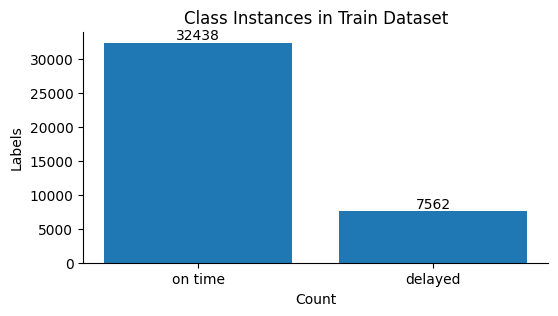


test:
 - Number of features:  768
 - Number of samples:  30000
[24224  5776]


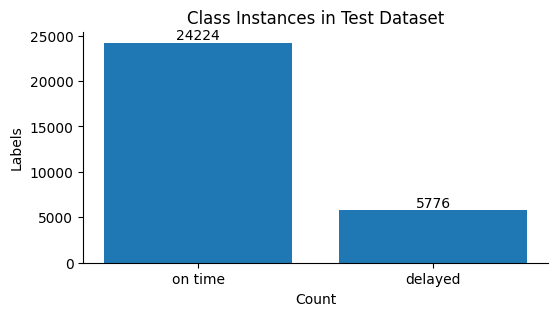


validation:
 - Number of features:  768
 - Number of samples:  30000
[24256  5744]


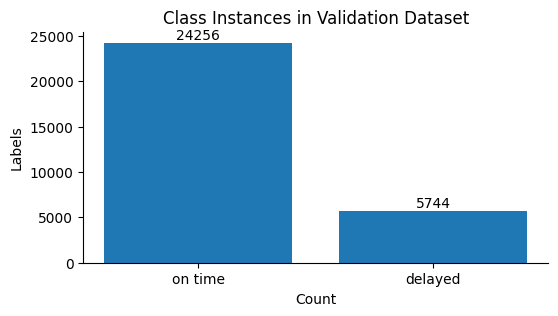

In [17]:
'''
process data for training, split into test/train/validation
'''
X = master_df.drop(columns=["ArrDel15"])
y = master_df[["ArrDel15"]]
y = y.ArrDel15.ravel() # flatten
print("# samples:", y.shape[0])

# split into train and test/validation (which is then split in next line)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,
                                                    test_size=0.6,
                                                    random_state=150)

# create validation and test sets each 15% of total data
X_test, X_validation, y_test, y_validation = train_test_split(X_test_val, y_test_val,
                                                    test_size=0.5,
                                                    random_state=150)
data = {"train": (X_train,y_train), "test":(X_test,y_test), "validation": (X_validation,y_validation)}

# number of classes, number of instances in each class
for each in data.keys():
    print(f"{each}:")
    print(" - Number of features: ", len(data[each][0].columns))
    print(" - Number of samples: ", len(data[each][0]))
    unique, counts = np.unique(data[each][1], return_counts=True)
    plot_freq(each, (unique, counts))
    print()

In [18]:
# create train numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_validation = X_validation.to_numpy()

# convert to tensors
X_train, y_train, X_test, y_test, X_validation, y_validation = map(
    torch.tensor, (X_train, y_train, X_test, y_test, X_validation, y_validation)
)

In [19]:
# create dataset and dataloader
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
valid_ds = TensorDataset(X_validation, y_validation)

In [20]:
loss_function = nn.BCEWithLogitsLoss()
num_features = X_train.shape[1]
classes = y_train.unique()

In [21]:
# exhaustive hyperparameter tuning based on the best final validation loss
def ffn_tune(num_hidden_layers, num_nodes, param_dict):
    best_model = {key:param_dict[key] for key in param_dict}
    best_model["best_loss"] = 100000000000
    for bs in param_dict["bs"]:
        for epoch in param_dict["epoch"]:
            for lr in param_dict["learning_rate"]:
                # use validation loss
                model = FeedForward(num_hidden_layers, num_nodes, num_features)
                training_losses, valid_losses = model.fit(train_ds, valid_ds, bs, epoch, loss_function, lr)
                if valid_losses[-1] < best_model["best_loss"]:
                    best_model["model"]=model
                    best_model["best_loss"] = valid_losses[-1]
                    best_model["epoch"] = epoch
                    best_model["learning_rate"] = lr
                    best_model["bs"] = bs
                    best_model["valid_losses"] = valid_losses
                    best_model["training_losses"] = training_losses
                print("best loss: ", best_model["best_loss"])
    return best_model


In [22]:
def ffn_evaluate(model):
# plot losses
    plt.plot(model["training_losses"], label="Training Loss")
    # print(model["training_losses"])
    plt.plot(model["valid_losses"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # calculate accuracy
    d = {"train": train_ds, "test": test_ds, "validation": valid_ds}
    for dataset in d:
        print(f"Evaluating **{dataset}** dataset:")
        mean_accuracy, class_accuracy, classifier_scores, confusion_matrix = model["model"].score(d[dataset], model["bs"])
        print(f"Mean Accuracy: {mean_accuracy*100:.3f}")
        print(f"Mean per-class accuracy:")
        for key in class_accuracy:
            print(f"  {'delayed' if key==1 else 'on time'}{': '}{class_accuracy[key]*100:.3f}%")
        print(f"Precision: {classifier_scores[0]}")
        print(f"Recall: {classifier_scores[1]}")
        print(f"F-Beta Score: {classifier_scores[2]}")
        print(f"F1 Score: {classifier_scores}")
        print(confusion_matrix)
        print()

4 Nodes, 1 Hidden Layer(s)


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]

best loss:  7.947285022661769e-12
best batch size:  64
best epoch:  50
best learning rate:  0.01


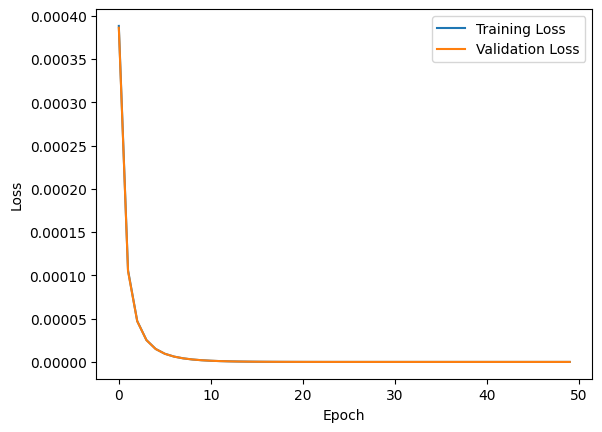

Evaluating **train** dataset:


100%|██████████| 625/625 [00:00<00:00, 1625.62it/s]


Mean Accuracy: 100.000
Mean per-class accuracy:
  on time: 100.000%
  delayed: 100.000%
Precision: [1. 1.]
Recall: [1. 1.]
F-Beta Score: [1. 1.]
F1 Score: (array([1., 1.]), array([1., 1.]), array([1., 1.]), array([32438,  7562]))
[[32438     0]
 [    0  7562]]

Evaluating **test** dataset:


100%|██████████| 469/469 [00:00<00:00, 1551.06it/s]


Mean Accuracy: 100.000
Mean per-class accuracy:
  on time: 100.000%
  delayed: 100.000%
Precision: [1. 1.]
Recall: [1. 1.]
F-Beta Score: [1. 1.]
F1 Score: (array([1., 1.]), array([1., 1.]), array([1., 1.]), array([24224,  5776]))
[[24224     0]
 [    0  5776]]

Evaluating **validation** dataset:


100%|██████████| 469/469 [00:00<00:00, 1602.44it/s]


Mean Accuracy: 100.000
Mean per-class accuracy:
  on time: 100.000%
  delayed: 100.000%
Precision: [1. 1.]
Recall: [1. 1.]
F-Beta Score: [1. 1.]
F1 Score: (array([1., 1.]), array([1., 1.]), array([1., 1.]), array([24256,  5744]))
[[24256     0]
 [    0  5744]]



In [23]:
# run model tuning and evaluation on the 4 combos of layers/nodes
def run_model(num_layers: int, num_nodes: int):
    params = {"bs":(64,),
            "epoch":(50,),
            "learning_rate":(.01,)}
    print(f"{num_nodes} Nodes, {num_layers} Hidden Layer(s)")
    best_model = ffn_tune(num_layers,num_nodes, params)
    print("best batch size: ", best_model["bs"])
    print("best epoch: ", best_model["epoch"])
    print("best learning rate: ", best_model["learning_rate"])
    ffn_evaluate(best_model)

    # TODO save model
    # state = best_model["model"].state_dict() # save the model

for pair in [(1,64)]:
    run_model(pair[0],pair[1])

# bs, epoch, learning_rate, momentum, activation function, number layers, number of nodes per hidden layer